In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
count = 0
for _, _, filenames in os.walk('/kaggle/input'):
    count += len(filenames)

print(f"Toplam dosya sayısı: {count}")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Toplam dosya sayısı: 7023


In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D,Flatten,Dense,Dropout,Input)

In [50]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator (preprocessing,augmentation,label encoding yapar)
# bu sınıf dataset RAM'e sığmadığında kullanılır

## Sıralama:

* Split: Veriyi Eğitim (%80) ve Test (%20) olarak ayır.(veri zaten ayrılmış)

* Preprocessing: Eğitim setinin istatistiklerine göre (boyutlandırma, parlaklık ayarı vb.) her iki seti de işle.

In [51]:
base_dir = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = os.path.join(base_dir,'Training')
test_dir = os.path.join(base_dir,'Testing')

## Augmentation
* Eldeki veri sabittir -> model bu veriyi ezberlemeye meyillidir.
* Augmentation : Aynı görününtün etiketi değişmeden farklı versiyonlarını üretir
* Ama diskte yeni dosya oluşturmaz her epoch'ta anlık (on-the-fly) yapılır
  

In [52]:
# Preprocessing ve Augmentation ayarları
train_datagen = ImageDataGenerator(
    rescale = 1./255, # [0,255] -> [0,1] piksel değeri
    rotation_range = 20, # modelin açıya ezber yapmasını engeller
    horizontal_flip= True, # ? çıkarılabilir
    validation_split= 0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [53]:
# verileri akış (flow) halinde yükleme
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# bunu sileyim mi
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = False  #Ölçüm yaparken asla karıştırma
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size = 32,
    class_mode='categorical',
    subset='validation'
)

Found 4571 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [54]:


def count_images_per_class(base_path):
    class_counts = {}
    for class_name in sorted(os.listdir(base_path)):
        class_path = os.path.join(base_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
    return class_counts


In [55]:
train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)
print(train_counts)
print(test_counts)

{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
{'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


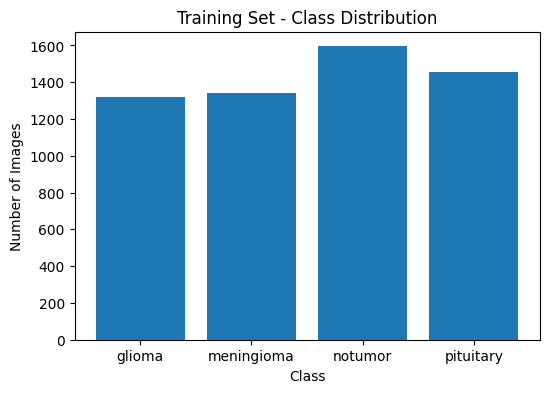

In [56]:
# Train + Test sınıf sayıları

plt.figure(figsize=(6,4))
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Training Set - Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

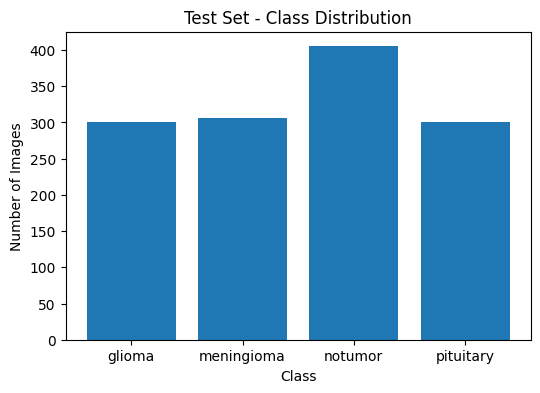

In [57]:
plt.figure(figsize=(6,4))
plt.bar(test_counts.keys(), test_counts.values())
plt.title("Test Set - Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


### CNN MODELİ

In [58]:
model = Sequential()

model = Sequential([
    Input(shape=(224, 224, 3)),
    
    # İlk katman: Filtre sayısını 32'den 64'e çıkardık
    Conv2D(64, (3, 3), activation='relu'), 
    MaxPooling2D(2, 2),
    
    # İkinci katman: Filtre sayısını 64'ten 128'e çıkardık
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Üçüncü bir katman eklemek detayları yakalamak için iyi olabilir (Opsiyonel)
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    
    # Karar katmanı
    Dense(128, activation='relu'),
    
    # --- YENİ: Dropout Katmanı ---
    # Eğitim sırasında nöronların %50'sini rastgele kapatır, ezberlemeyi önler.
    Dropout(0.5), 
    
    Dense(4, activation='softmax')
])

In [59]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,299,460 (43.10 MB)

 Trainable params: 11,299,460 (43.10 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
#Eğitim Adımı
# 'epochs=10' modelin veri setini 10 kez baştan sonra okuyacağı anlamına gelir

history = model.fit(train_generator,validation_data=validation_generator,epochs=10)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2026-01-13 09:19:25.678428: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-13 09:19:25.860980: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 36/143 ━━━━━━━━━━━━━━━━━━━━ 40s 380ms/step - accuracy: 0.4235 - loss: 1.4290

2026-01-13 09:19:49.005905: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-13 09:19:49.183910: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 578ms/step - accuracy: 0.5551 - loss: 1.0705 - val_accuracy: 0.5925 - val_loss: 1.1208
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 480ms/step - accuracy: 0.7998 - loss: 0.5182 - val_accuracy: 0.7800 - val_loss: 0.6347
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 477ms/step - accuracy: 0.8481 - loss: 0.4043 - val_accuracy: 0.7651 - val_loss: 0.6177
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 476ms/step - accuracy: 0.8661 - loss: 0.3455 - val_accuracy: 0.8160 - val_loss: 0.5823
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 475ms/step - accuracy: 0.8863 - loss: 0.3049 - val_accuracy: 0.7958 - val_loss: 0.5803
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 474ms/step - accuracy: 0.8952 - loss: 0.2753 - val_accuracy: 0.8317 - val_loss: 0.5581
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 473ms/step - accuracy: 0.9060 - loss: 0.2430 - val_accuracy: 0.8370 - val_loss: 0.4635
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - accuracy: 0.9031 - loss: 0.2561 - val

## Model Başarı Ölçümü

### Temel Başarı Metrikleri
* *Accuracy(Doğruluk):* Toplam tahminler içinde doğru olanların oranı.Dengesiz veri setlerinde yanıltıcı olabilir.
*  *Precision(Kesinlik)* : Tümör olarak tahmin edilenlerin kaçı gerçekten tümör
*  *Recall(Duyarlılık)* : Tıpta en önemli metrik budur.Gerçekten tümor olan hastaların kaçta kaçı yakalandı?
*  *F1-Score:* Precision ve Recall değerlerinin dengeli bir ortalamasıdır. Modelin genel kalitesini gösteren en dürüst değerdir.

### AUC-ROC Eğrisi 
* Modelin sınıfları birbirinden ayırt etme gücünü temsil eder. Alan(AUC) 1.0'a ne kadar yakınsa modelin tümörlü ve tümörsüz dokuyu ayırma yeteneği o kadar mükemmeldir.

In [61]:
test_generator.reset() # sırayı garantilemek için jeneratörü sıfırla
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)
y_true = test_generator.classes

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step
[[263  34   1   2]
 [ 26 187  77  16]
 [  2   1 402   0]
 [  1   4   3 292]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       300
           1       0.83      0.61      0.70       306
           2       0.83      0.99      0.91       405
           3       0.94      0.97      0.96       300

    accuracy                           0.87      1311
   macro avg       0.88      0.86      0.86      1311
weighted avg       0.87      0.87      0.87      1311



In [1]:
# 1. Doğruluk (Accuracy) Grafiği
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2. Kayıp (Loss) Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

NameError: name 'plt' is not defined